In [ ]:
# Import necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(train_ds, val_ds), ds_info = tfds.load(name="cats_vs_dogs", split=('train[:20%]','train[-5%:]'), as_supervised=True, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteT59019/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='~/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and

# Preprocessing the data

In [ ]:
ds_info.splits['train'].num_examples

23262

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label
  
num_examples = ds_info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().map(format_image).batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)

In [ ]:
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_hub as hub
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(url, input_shape = (IMAGE_RES, IMAGE_RES, 3))

In [ ]:
feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2)
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [ ]:
epochs = 2
history = model.fit(train_ds,
                    epochs = epochs,
                    validation_data = val_ds)

Epoch 1/2
146/146 [==============================] - 9s 64ms/step - loss: 0.0262 - accuracy: 0.9931 - val_loss: 0.0310 - val_accuracy: 0.9862
Epoch 2/2
146/146 [==============================] - 6s 44ms/step - loss: 0.0220 - accuracy: 0.9948 - val_loss: 0.0297 - val_accuracy: 0.9897


In [ ]:
class_names  = np.array(ds_info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [ ]:
image_batch, label_batch = next(iter(train_ds.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_class_name = class_names[predicted_ids]
predicted_class_name

1/1 [==============================] - 2s 2s/step


array(['dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat',
       'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog',
       'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog',
       'cat', 'cat', 'dog', 'cat', 'cat'], dtype='<U3')

In [ ]:
print('True Labels:', label_batch)
print('Predicted Labels:', predicted_ids)

True Labels: [1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0]
Predicted Labels: [1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0]


# Visualization

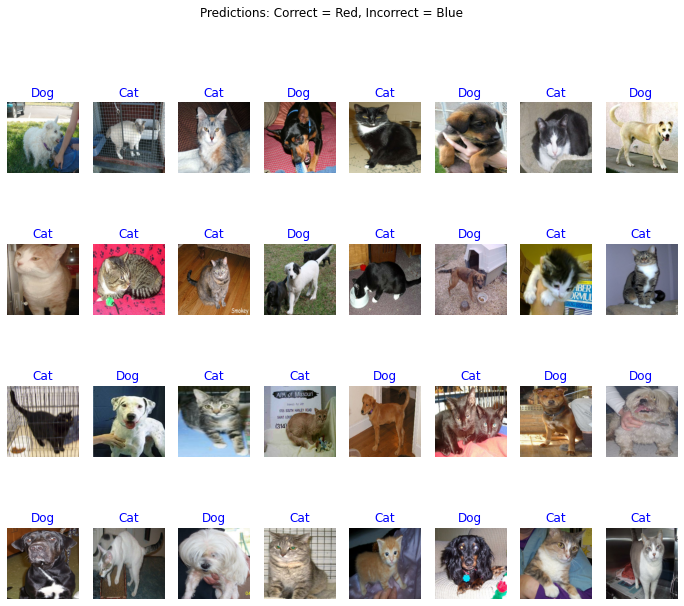

In [ ]:
plt.figure(figsize=(12,10))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(image_batch[i])
  color = 'blue' if predicted_ids[i] == label_batch[i] else 'resize'
  plt.title(predicted_class_name[i].title(), color = color)
  plt.axis('off')
  plt.suptitle('Predictions: Correct = Red, Incorrect = Blue')

# Save the model

In [ ]:
import time

t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1670476604.h5


In [ ]:
!ls

'~'   1670476604.h5   sample_data


In [ ]:
reloaded_model = tf.keras.models.load_model(export_path_keras,
                                            custom_objects = {'KerasLayer': hub.KerasLayer})
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
reloaded_result_batch = reloaded_model.predict(image_batch)

1/1 [==============================] - 1s 1s/step


In [ ]:
reloaded_result_batch

array([[-4.2086334,  4.0186768],
       [-0.7727471, -1.4819971],
       [ 4.901535 , -5.794226 ],
       [-3.115012 ,  5.1150336],
       [ 6.6015415, -7.1258235],
       [-4.600745 ,  2.7153857],
       [ 3.749441 , -5.4648476],
       [-3.4880514,  2.8440425],
       [ 5.1868315, -5.7875924],
       [ 5.8227177, -5.6224675],
       [ 3.240061 , -3.583927 ],
       [-4.6615505,  4.57337  ],
       [ 3.2902744, -2.1261783],
       [-4.896839 ,  2.7733064],
       [ 4.895977 , -6.6290445],
       [ 3.7221947, -4.3081756],
       [ 3.766438 , -4.657996 ],
       [-5.6867533,  4.7234797],
       [ 5.943782 , -6.089878 ],
       [ 5.392474 , -7.550307 ],
       [-4.10723  ,  2.617248 ],
       [ 6.211625 , -7.170113 ],
       [-5.126685 ,  4.3968215],
       [-3.4399736,  2.8445055],
       [-3.5117047,  2.7416732],
       [ 5.72351  , -5.3615785],
       [-4.1323605,  3.5624564],
       [ 4.5553074, -5.280528 ],
       [ 5.51534  , -7.542989 ],
       [-2.106782 ,  2.9878645],
       [ 5

# Compare basic CNN model

In [ ]:
cnn_model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
cnn_model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
epochs = 8
cnn_history = cnn_model.fit(train_ds,
                    epochs = epochs,
                    validation_data = val_ds)

Epoch 1/8
146/146 [==============================] - 10s 65ms/step - loss: 0.3656 - accuracy: 0.8293 - val_loss: 0.7344 - val_accuracy: 0.6629
Epoch 2/8
146/146 [==============================] - 10s 67ms/step - loss: 0.2029 - accuracy: 0.9125 - val_loss: 0.9531 - val_accuracy: 0.6655
Epoch 3/8
146/146 [==============================] - 10s 67ms/step - loss: 0.1192 - accuracy: 0.9561 - val_loss: 1.2806 - val_accuracy: 0.6552
Epoch 4/8
146/146 [==============================] - 9s 64ms/step - loss: 0.0643 - accuracy: 0.9776 - val_loss: 1.3460 - val_accuracy: 0.6698
Epoch 5/8
146/146 [==============================] - 9s 64ms/step - loss: 0.0346 - accuracy: 0.9880 - val_loss: 1.9044 - val_accuracy: 0.6647
Epoch 6/8
146/146 [==============================] - 10s 66ms/step - loss: 0.0302 - accuracy: 0.9888 - val_loss: 1.8344 - val_accuracy: 0.6552
Epoch 7/8
146/146 [==============================] - 9s 64ms/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 1.9219 - val_accuracy: 0.6672
Ep